In [1]:
#importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC, NuSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay, ConfusionMatrixDisplay, roc_auc_score, auc, accuracy_score, f1_score, confusion_matrix, mean_squared_error
from sklearn import tree 
import xgboost as xgb_package
import seaborn as sns

In [2]:
#reading files
all_pairs = pd.read_csv("all_pairs.csv", sep= ";")
all_pairs = all_pairs.dropna(how='all')              # drops fully empty rows
all_pairs = all_pairs.dropna(axis=1, how='all')      # drops fully empty columns

In [3]:
npos = len(all_pairs[all_pairs['neighbour biomarker for target?'] == 1])
print(npos)

332


In [4]:
# Option A - Random sampling
training_pos =all_pairs[all_pairs['neighbour biomarker for target?'] == 1]
training_neg = all_pairs[all_pairs['neighbour biomarker for target?'] == 0].sample(n=npos, random_state=42)

In [5]:
# Option B - not biomarker in CIViCmine
training_neg = all_pairs[
    (all_pairs['neighbour biomarker for target?'] == 0) &
    (all_pairs['prognostic'] == 0) &
    (all_pairs['predisposing'] == 0) &
    (all_pairs['diagnostic'] == 0) &
    (all_pairs['predictive'] == 0)]
training_neg.shape

(548, 84)

In [6]:
training = pd.concat([training_pos, training_neg], ignore_index=True)

In [7]:
unknown = all_pairs.merge(training, how='outer', indicator=True)\
                          .query('_merge == "left_only"')\
                          .drop(columns=['_merge'])

In [8]:
unknown

,neighbour UniProt,neighbour name - universal,neighbour in CSN,neighbour in SIGNOR,neighbour in ReactomeFI,neighbour DisProt IDP,neighbour DisProt disorder content,neighbour in AlphaFold,neighbour AlphaFold average pLLDT,neighbour AlphaFold disorder %,...,target betweenness - SIGNOR,neighbour bridgeness - ReactomeFI,neighbour betweenness - ReactomeFI,target bridgeness - ReactomeFI,target betweenness - ReactomeFI,prognostic,predisposing,diagnostic,predictive,neighbour biomarker for target?
0,Q00535,CDK5,1,1,1,0,0.00,1,91.441641,0.000000,...,307930.86800,0.339772,2.855303e+04,1.719448,104769.645900,1,1,1,1,0
1,P16333,NCK1,1,1,1,1,13.26,1,71.827032,21.662802,...,307930.86800,0.043965,1.400557e+04,1.719448,104769.645900,1,0,0,0,0
2,Q13153,PAK1,1,1,1,1,48.44,1,73.654483,30.394922,...,307930.86800,0.647834,2.578884e+04,1.719448,104769.645900,1,1,1,1,0
3,P27348,14-3-3,1,1,1,0,0.00,1,93.988432,3.547558,...,51550.04317,1.457216,9.568660e+03,0.009968,121479.075300,1,0,0,0,0
4,O14727,APAF1,1,1,1,1,8.33,1,85.250516,1.335341,...,51550.04317,0.011504,8.795059e+03,0.009968,121479.075300,1,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4545,P07949,RET,0,1,1,0,0.00,1,79.442057,18.043478,...,0.00000,0.005026,2.301270e+03,0.007312,6021.974584,1,1,1,1,0
4546,P08047,SP1,1,1,1,1,29.17,1,39.865572,85.238938,...,0.00000,5.359817,1.258761e+06,0.007312,6021.974584,1,1,1,1,0
4547,P40763,STAT3,1,1,1,1,4.42,1,85.765626,9.204141,...,0.00000,21.209909,9.184688e+05,0.007312,6021.974584,1,1,1,1,0
4548,Q02763,TEK,0,1,1,0,0.00,1,84.579688,6.496887,...,0.00000,0.015176,1.421442e+04,0.007312,6021.974584,1,0,1,1,0


In [9]:
#titles list
titles = list(training.head())
CSN = [s for s in titles if "CSN" in s]
SIGNOR = [s for s in titles if "SIGNOR" in s]
ReactomeFI = [s for s in titles if "ReactomeFI" in s]
print(CSN, SIGNOR, ReactomeFI)

['neighbour in CSN', 'target in CSN', 'both in CSN', 'in triangle - CSN', 'no. of triangles - CSN', 'no. of in cycle - CSN', 'no. of in unbalanced triangle - CSN', 'neighbour – target inhibition - CSN', 'target – neighbour stimulation - CSN', 'neighbour – target stimulation - CSN', 'target – neighbour inhibition - CSN', 'DisProt neighbour third partner - CSN', 'target third partner - CSN', 'neighbour bridgeness - CSN', 'neighbour betweenness - CSN', 'target bridgeness - CSN', 'target betweenness - CSN'] ['neighbour in SIGNOR', 'target in SIGNOR', 'both in SIGNOR', 'in  triangle - SIGNOR', 'no. of triangles - SIGNOR', 'no. of in  cycle - SIGNOR', 'no. of in  unbalanced triangle - SIGNOR', 'neighbour – target inhibition - SIGNOR', 'target – neighbour stimulation - SIGNOR', 'neighbour – target stimulation - SIGNOR', 'target – neighbour inhibition - SIGNOR', 'DisProt neighbour third partner - SIGNOR', 'target third partner - SIGNOR', 'neighbour bridgeness - SIGNOR', 'neighbour betweenness 

In [10]:
#what to drop - first option
to_drop = ["neighbour UniProt", "neighbour name - universal", "target UniProt", "target name - universal", "predictive"]
only_CSN = to_drop + SIGNOR + ReactomeFI
only_SIGNOR = to_drop + CSN + ReactomeFI 
only_ReactomeFI = to_drop + CSN + SIGNOR

In [11]:
#what to drop - second option
to_drop = ["neighbour UniProt", "neighbour name - universal", "target UniProt", "target name - universal", 
           "prognostic", "predisposing", "diagnostic", "predictive"]
only_CSN = to_drop + SIGNOR + ReactomeFI
only_SIGNOR = to_drop + CSN + ReactomeFI 
only_ReactomeFI = to_drop + CSN + SIGNOR

In [12]:
#classifiers - option A (random)
xgb = xgb_package.XGBClassifier(n_estimators=1000,
                                random_state= 42,
                                subsample= 0.5,
                                scale_pos_weight= 0.5,
                                reg_lambda= 0.25,
                                reg_alpha= 0.5,
                                min_child_weight= 0.5,
                                max_leaves= 5,
                                max_depth= 9,
                                max_delta_step= 0,
                                max_bin= 8,
                                learning_rate= 0.5,
                                importance_type= 'weight',
                                grow_policy= 'lossguide',
                                gamma= 0.5,
                                criterion= 'entropy',
                                booster= 'dart')
rfc = RandomForestClassifier(n_estimators=1000,
                             random_state= 42,
                             warm_start= False,
                             oob_score= False,
                             n_jobs= 31,
                             min_weight_fraction_leaf= 0,
                             min_samples_split= 4,
                             min_samples_leaf= 3,
                             max_samples= 61,
                             max_leaf_nodes= 27,
                             max_features= None,
                             max_depth= 5,
                             criterion= 'log_loss',
                             class_weight= 'balanced',
                             ccp_alpha= 0)

In [13]:
#classifiers - option B (not biomarker in CIViCmine)
xgb = xgb_package.XGBClassifier(n_estimators=1000,
                                random_state=42,
                                subsample= 0.75,
                                scale_pos_weight= 0.25,
                                reg_lambda= 0,
                                reg_alpha= 0.5,
                                min_child_weight= 0.5,
                                max_leaves= 11,
                                max_depth= 7,
                                max_delta_step= 1,
                                max_bin= 32,
                                learning_rate= 1,
                                importance_type= 'cover',
                                grow_policy= 'lossguide',
                                gamma= 0.5,
                                criterion= 'log_loss',
                                booster= 'gbtree')
rfc = RandomForestClassifier(n_estimators=1000,
                             random_state= 42,
                             warm_start= False, #disabled, otherwise gives error with multiple training sets
                             oob_score= False,
                             n_jobs= 31,
                             min_weight_fraction_leaf= 0.1,
                             min_samples_split= 4,
                             min_samples_leaf= 5,
                             max_samples= 71,
                             max_leaf_nodes= 29,
                             max_features= 'sqrt',
                             max_depth= 3,
                             criterion= 'log_loss',
                             class_weight= 'balanced',
                             ccp_alpha= 0)

In [14]:
training_deleted = training.drop(columns= to_drop)
U = unknown.drop(columns= to_drop)
X = training_deleted.iloc[:,:-1]
y = training_deleted.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [15]:
#data preparation
def prepare_data_split(training=training, unknown=unknown, to_drop= to_drop):
    """
    This function prepares the training, test and unknown data for the machine learning.
    Drops the previously selected columns using the to_drop list without renaming the remaining columns.
    Splits the training data to input parameters and labels.
    Splits the training data via 70:30 split to final training and test datasets.

    Args:
        to_drop: The list of column names which are going to be dropped from the training and unknown dataframe. 
        training: The dataframe of input parameters which are intended to use to the training of the machine learning model.
        unknown: The dataframe of input parameters which are intended to use to the testing of the machine learning model.

    Returns:
        U: The input data from the unknown dataframe.
        X_train: The 70% input data from the training dataframe which later be used for training the model.
        X_test: The 30% input data from the training dataframe which later be used for testing the model.
        y_train: The labels for the X_train dataframe.
        y_test: The labels for the X_test dataframe.

    """
    training_deleted = training.drop(columns= to_drop)
    U = unknown.drop(columns= to_drop)
    X = training_deleted.iloc[:,:-1]
    y = training_deleted.iloc[:, -1]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
    return U, X_train, X_test, y_train, y_test

In [16]:
#training - ROC graph, CM, scores
def teach_print_test_all(X_train, X_test, y_train, y_test, classifier, what):
    """
    This function teaches and tests the selected machine learning models while also calculating different metrics.
    Fits StandardScaler on the training data and transforms the training and test data.
    Makes predictions on the training and test dataframes.
    Calculates and returns accuracy, F1 score and ROC AUC.
    Based on selection, draws the ROC or PR curve.

    Args:
        X_train: The input data which will be used for training the model.
        X_test: The input data which will be used for testing the model.
        y_train: The labels for the X_train dataframe.
        y_test: The labels for the X_test dataframe.
        classifier: The choosen classification algorhythm.
        what: The selected graph drawn based on the performance of the classificator. Options: "ROC" or "PR".

    Returns:
        classifier_pred_train: Predictions on the training dataset.
        classifier_pred_test: Predictions on the test dataset.
        display: The display of the choosen graph.
        params: The list of the calculated metrics, such as accuracy, FR score, ROC AUC.

    """
    #fitting scale
    scale = StandardScaler()
    scale.fit(X_train)
    X_train = scale.transform(X_train)
    X_test = scale.transform(X_test)
        
    #training
    classifier.fit(X_train, y_train)

    classifier_pred_train = classifier.predict(X_train)
    classifier_pred_test = classifier.predict(X_test)
    
    #accuracy+f1+auc
    acc = accuracy_score(y_test, classifier_pred_test)
    f1 = f1_score(y_test, classifier_pred_test)
    test_auc = roc_auc_score(y_test, classifier_pred_test)
    params= [acc, f1, test_auc]
    print(f"Accuracy: {acc}\n F1 score: {f1}\n Test AUC: {test_auc}")  
    print(params)    
    
    # Calculate sensitivity and specificity from confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_test, classifier_pred_test).ravel()
    
    sensitivity = tp / (tp + fn)  # True Positive Rate (Recall)
    specificity = tn / (tn + fp)  # True Negative Rate
    print(f"Sensitivity: {sensitivity}")
    print(f"Specificity: {specificity}")
    
    #test ROC curve
    if what == "ROC":
        ax1 = plt.gca()
        display = RocCurveDisplay.from_estimator(classifier, X_test, y_test, ax=ax1, alpha=0.8)
        #plt.show()
    
    #precision recall
    elif what == "PR":
        ax2 = plt.gca()
        display = PrecisionRecallDisplay.from_estimator(classifier, X_test, y_test, ax=ax2, alpha=0.8)
        #plt.show() 
        
    else: 
        print("Please give a valid option.")
    
    return classifier_pred_train, classifier_pred_test, display, params

In [17]:
def params_heatmap(params_xgb, params_rfc):
    """
    This function draws heatmap based on the performance metrics of the XGBoost and Random Forest algorhythms.
    Puts the input parameters into a dictionary, then into a dataframe.
    Transposes the dataframe to make the heatmap more easily understandable.
    Sets the name of the columns based on the name of the parameters: "Accuracy", "F1-score", "Test AUC score".
    Draws the heatmap.
    Returms the dataframe of the parameters.

    Args:
        params_xgb: Accuracy, F1-score, test AUC score for the XGBoost algorhythm.
        params_rfc: Accuracy, F1-score, test AUC score for the Random Forest algorhythm.

    Returns:
        params: Dataframe of the XGBoost and Random forest parameters.

    """
    params_dict = {'XGBoost': params_xgb, 'Random forest': params_rfc}
    print(dict)
    params = pd.DataFrame(params_dict)
    params = params.transpose()
    params = params.set_axis(["Accuracy", "F1-score", "Test AUC score"], axis=1)
    sns.heatmap(params, annot=True, vmin=0.5, vmax=1)
    print(params)
    return params

XGBoost results:
[19:51:44] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Accuracy: 0.9545454545454546
 F1 score: 0.9361702127659574
 Test AUC: 0.9464285714285713
[0.9545454545454546, 0.9361702127659574, 0.9464285714285713]
Sensitivity: 0.9166666666666666
Specificity: 0.9761904761904762
Random forest results:
Accuracy: 0.9015151515151515
 F1 score: 0.8645833333333333
 Test AUC: 0.8936011904761907
[0.9015151515151515, 0.8645833333333333, 0.8936011904761907]
Sensitivity: 0.8645833333333334
Specificity: 0.9226190476190477


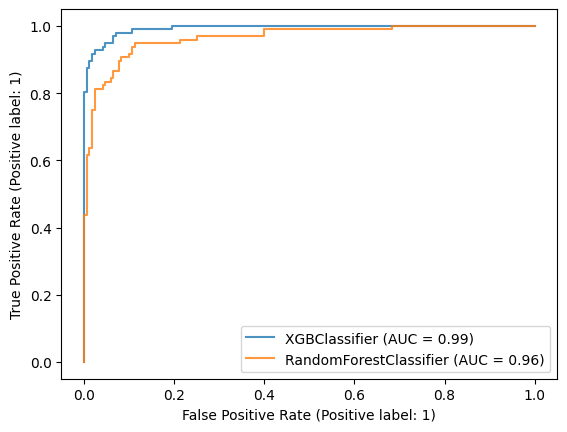

XGBoost results:
[19:51:48] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Accuracy: 0.9545454545454546
 F1 score: 0.9361702127659574
 Test AUC: 0.9464285714285713
[0.9545454545454546, 0.9361702127659574, 0.9464285714285713]
Sensitivity: 0.9166666666666666
Specificity: 0.9761904761904762
Random forest results:
Accuracy: 0.9015151515151515
 F1 score: 0.8645833333333333
 Test AUC: 0.8936011904761907
[0.9015151515151515, 0.8645833333333333, 0.8936011904761907]
Sensitivity: 0.8645833333333334
Specificity: 0.9226190476190477


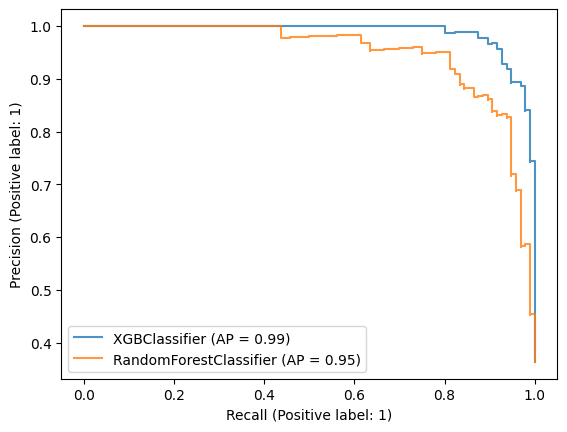

<class 'dict'>
               Accuracy  F1-score  Test AUC score
XGBoost        0.954545  0.936170        0.946429
Random forest  0.901515  0.864583        0.893601


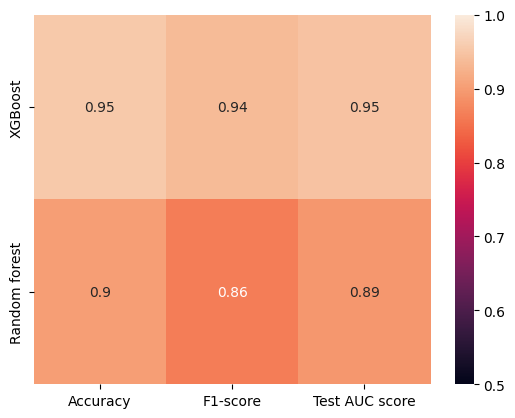

In [18]:
#basic
#ROC
U, X_train, X_test, y_train, y_test = prepare_data_split(to_drop=to_drop)
print("XGBoost results:")
xgb_pred_train, xgb_pred_test, display_xgb, params_xgb = teach_print_test_all(X_train, X_test, y_train, y_test, 
                                                                 classifier=xgb, what="ROC")
print("Random forest results:")
rfc_pred_train, rfc_pred_test, display_rfc, params_rfc = teach_print_test_all(X_train, X_test, y_train, y_test, 
                                                                 classifier=rfc, what="ROC")
#print("SVM results:")
#svm_pred_train, svm_pred_test, display_svm, params_svm = teach_print_test_all(X_train, X_test, y_train, y_test, 
                                                                 #classifier=svm, what="ROC")
plt.plot(data= [display_xgb, display_rfc])#, display_svm])
plt.show()
#PR
print("XGBoost results:")
xgb_pred_train, xgb_pred_test, display_xgb, params_xgb = teach_print_test_all(X_train, X_test, y_train, y_test, 
                                                                 classifier=xgb, what="PR")
print("Random forest results:")
rfc_pred_train, rfc_pred_test, display_rfc, params_rfc = teach_print_test_all(X_train, X_test, y_train, y_test, 
                                                                 classifier=rfc, what="PR")
#print("SVM results:")
#svm_pred_train, svm_pred_test, display_svm, params_svm = teach_print_test_all(X_train, X_test, y_train, y_test, 
                                                                 #classifier=svm, what="PR")
plt.plot(data= [display_xgb, display_rfc])#, display_svm])
plt.show()
#heatmap
params_df = params_heatmap(params_xgb=params_xgb, params_rfc=params_rfc)#, params_svm=params_svm)

XGBoost results:
[19:51:52] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Accuracy: 0.9356060606060606
 F1 score: 0.907103825136612
 Test AUC: 0.9203869047619048
[0.9356060606060606, 0.907103825136612, 0.9203869047619048]
Sensitivity: 0.8645833333333334
Specificity: 0.9761904761904762
Random forest results:
Accuracy: 0.9015151515151515
 F1 score: 0.8571428571428572
 Test AUC: 0.8824404761904762
[0.9015151515151515, 0.8571428571428572, 0.8824404761904762]
Sensitivity: 0.8125
Specificity: 0.9523809523809523


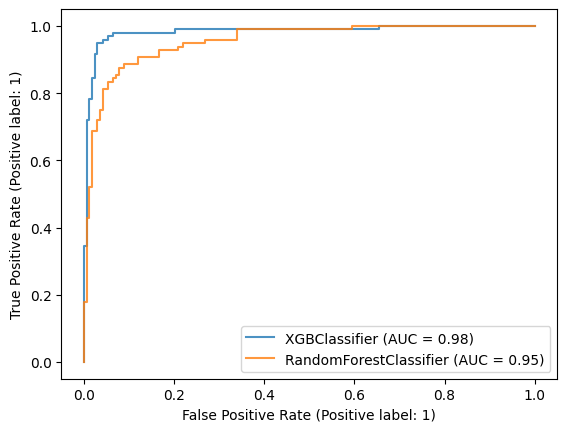

XGBoost results:
[19:51:55] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Accuracy: 0.9356060606060606
 F1 score: 0.907103825136612
 Test AUC: 0.9203869047619048
[0.9356060606060606, 0.907103825136612, 0.9203869047619048]
Sensitivity: 0.8645833333333334
Specificity: 0.9761904761904762
Random forest results:
Accuracy: 0.9015151515151515
 F1 score: 0.8571428571428572
 Test AUC: 0.8824404761904762
[0.9015151515151515, 0.8571428571428572, 0.8824404761904762]
Sensitivity: 0.8125
Specificity: 0.9523809523809523


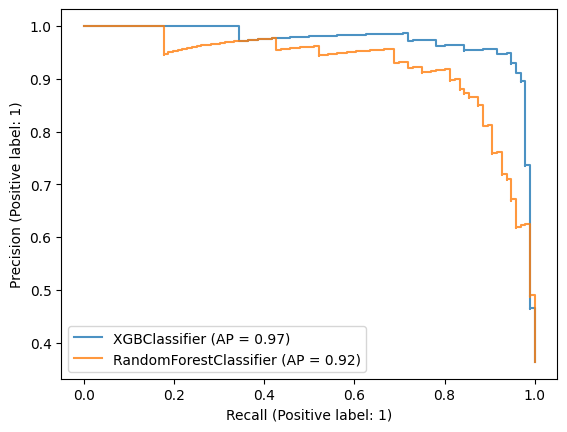

<class 'dict'>
               Accuracy  F1-score  Test AUC score
XGBoost        0.935606  0.907104        0.920387
Random forest  0.901515  0.857143        0.882440


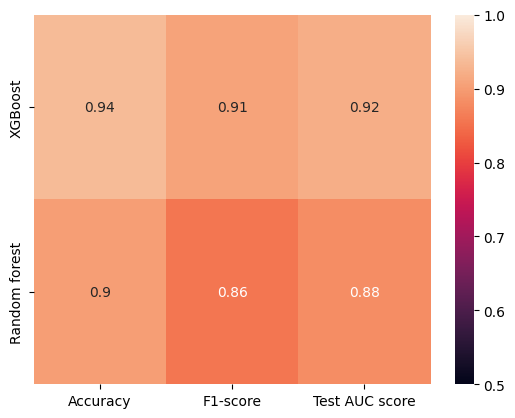

In [19]:
#CSN
#ROC
U, X_train_CSN, X_test_CSN, y_train, y_test = prepare_data_split(to_drop=only_CSN)
print("XGBoost results:")
xgb_pred_train_, xgb_pred_test, display_xgb_CSN, params_xgb_CSN = teach_print_test_all(X_train_CSN, X_test_CSN, 
                                                                                       y_train, y_test, 
                                                                                       classifier=xgb, what="ROC")
print("Random forest results:")
rfc_pred_train, rfc_pred_test, display_rfc_CSN, params_rfc_CSN = teach_print_test_all(X_train_CSN, X_test_CSN, 
                                                                                      y_train, y_test, 
                                                                                      classifier=rfc, what="ROC")
plt.plot(data= [display_xgb_CSN, display_rfc_CSN])
plt.show()
#PR
print("XGBoost results:")
xgb_pred_train, xgb_pred_test, display_xgb_CSN, params_xgb_CSN = teach_print_test_all(X_train_CSN, X_test_CSN, 
                                                                                      y_train, y_test, 
                                                                                      classifier=xgb, what="PR")
print("Random forest results:")
rfc_pred_train, rfc_pred_test, display_rfc_CSN, params_rfc_CSN = teach_print_test_all(X_train_CSN, X_test_CSN, 
                                                                                      y_train, y_test, 
                                                                                      classifier=rfc, what="PR")
plt.plot(data= [display_xgb_CSN, display_rfc_CSN])
plt.show()
#heatmap
params_df_CSN = params_heatmap(params_xgb=params_xgb_CSN, params_rfc=params_rfc_CSN)

XGBoost results:
[19:51:59] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Accuracy: 0.9431818181818182
 F1 score: 0.9197860962566845
 Test AUC: 0.9330357142857143
[0.9431818181818182, 0.9197860962566845, 0.9330357142857143]
Sensitivity: 0.8958333333333334
Specificity: 0.9702380952380952
Random forest results:
Accuracy: 0.9090909090909091
 F1 score: 0.8811881188118813
 Test AUC: 0.9129464285714286
[0.9090909090909091, 0.8811881188118813, 0.9129464285714286]
Sensitivity: 0.9270833333333334
Specificity: 0.8988095238095238


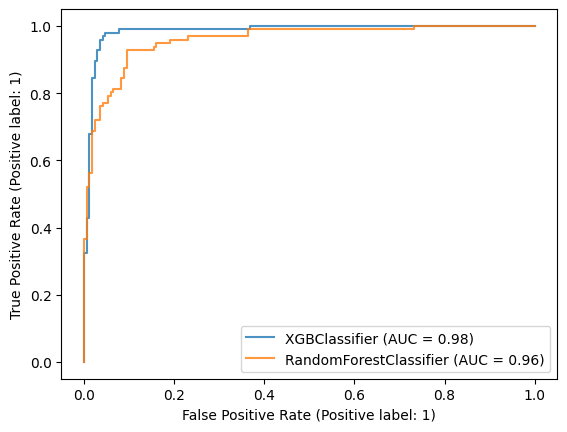

XGBoost results:
[19:52:03] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Accuracy: 0.9431818181818182
 F1 score: 0.9197860962566845
 Test AUC: 0.9330357142857143
[0.9431818181818182, 0.9197860962566845, 0.9330357142857143]
Sensitivity: 0.8958333333333334
Specificity: 0.9702380952380952
Random forest results:
Accuracy: 0.9090909090909091
 F1 score: 0.8811881188118813
 Test AUC: 0.9129464285714286
[0.9090909090909091, 0.8811881188118813, 0.9129464285714286]
Sensitivity: 0.9270833333333334
Specificity: 0.8988095238095238


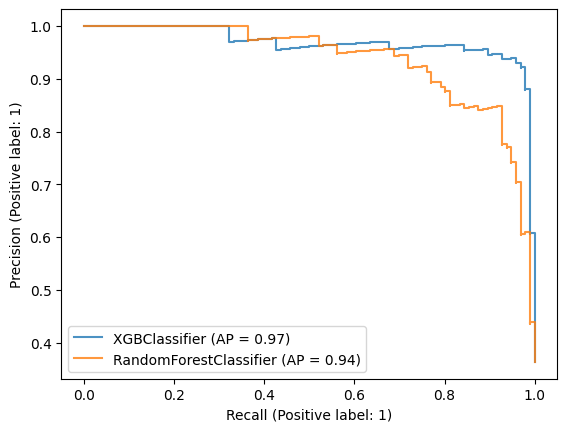

<class 'dict'>
               Accuracy  F1-score  Test AUC score
XGBoost        0.943182  0.919786        0.933036
Random forest  0.909091  0.881188        0.912946


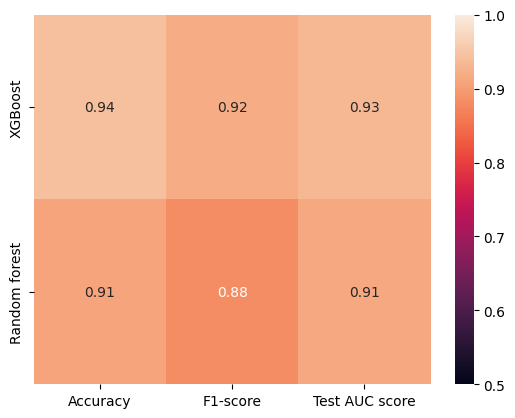

In [20]:
#SIGNOR
#ROC
U, X_train_SIGNOR, X_test_SIGNOR, y_train, y_test = prepare_data_split(to_drop=only_SIGNOR)
print("XGBoost results:")
xgb_pred_train_, xgb_pred_test, display_xgb_SIGNOR, params_xgb_SIGNOR = teach_print_test_all(X_train_SIGNOR, X_test_SIGNOR, 
                                                                                             y_train, y_test, 
                                                                                             classifier=xgb, what="ROC")
print("Random forest results:")
rfc_pred_train, rfc_pred_test, display_rfc_SIGNOR, params_rfc_SIGNOR = teach_print_test_all(X_train_SIGNOR, X_test_SIGNOR, 
                                                                                            y_train, y_test, 
                                                                                             classifier=rfc, what="ROC")
plt.plot(data= [display_xgb_SIGNOR, display_rfc_SIGNOR])
plt.show()
#PR
print("XGBoost results:")
xgb_pred_train, xgb_pred_test, display_xgb_SIGNOR, params_xgb_SIGNOR = teach_print_test_all(X_train_SIGNOR, X_test_SIGNOR, 
                                                                                            y_train, y_test, 
                                                                                             classifier=xgb, what="PR")
print("Random forest results:")
rfc_pred_train, rfc_pred_test, display_rfc_SIGNOR, params_rfc_SIGNOR = teach_print_test_all(X_train_SIGNOR, X_test_SIGNOR, 
                                                                                            y_train, y_test, 
                                                                                             classifier=rfc, what="PR")
plt.plot(data= [display_xgb_SIGNOR, display_rfc_SIGNOR])
plt.show()
#heatmap
params_df_SIGNOR = params_heatmap(params_xgb=params_xgb_SIGNOR, params_rfc=params_rfc_SIGNOR)

XGBoost results:
[19:52:07] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Accuracy: 0.946969696969697
 F1 score: 0.923076923076923
 Test AUC: 0.9315476190476192
[0.946969696969697, 0.923076923076923, 0.9315476190476192]
Sensitivity: 0.875
Specificity: 0.9880952380952381
Random forest results:
Accuracy: 0.8977272727272727
 F1 score: 0.8571428571428571
 Test AUC: 0.8861607142857143
[0.8977272727272727, 0.8571428571428571, 0.8861607142857143]
Sensitivity: 0.84375
Specificity: 0.9285714285714286


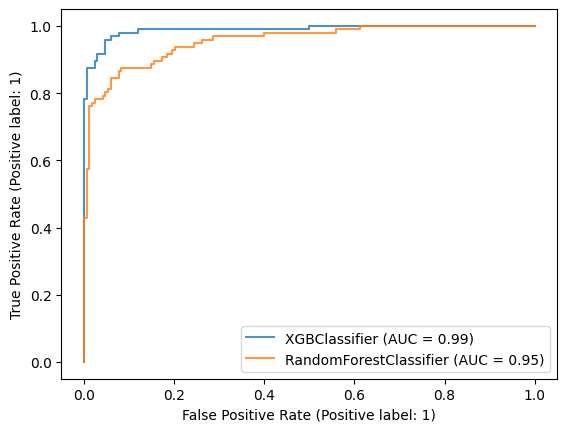

XGBoost results:
[19:52:10] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Accuracy: 0.946969696969697
 F1 score: 0.923076923076923
 Test AUC: 0.9315476190476192
[0.946969696969697, 0.923076923076923, 0.9315476190476192]
Sensitivity: 0.875
Specificity: 0.9880952380952381
Random forest results:
Accuracy: 0.8977272727272727
 F1 score: 0.8571428571428571
 Test AUC: 0.8861607142857143
[0.8977272727272727, 0.8571428571428571, 0.8861607142857143]
Sensitivity: 0.84375
Specificity: 0.9285714285714286


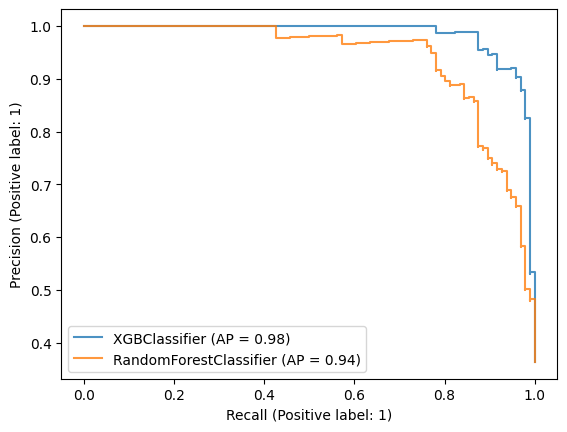

<class 'dict'>
               Accuracy  F1-score  Test AUC score
XGBoost        0.946970  0.923077        0.931548
Random forest  0.897727  0.857143        0.886161


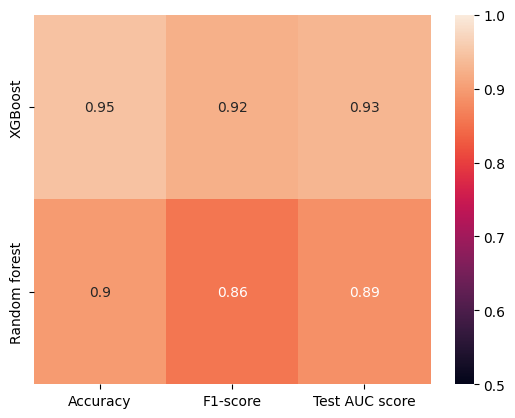

In [21]:
#ReactomeFI
#ROC
U, X_train_ReactomeFI, X_test_ReactomeFI, y_train, y_test = prepare_data_split(to_drop=only_ReactomeFI)
print("XGBoost results:")
xgb_pred_train_, xgb_pred_test, display_xgb_ReactomeFI, params_xgb_ReactomeFI = teach_print_test_all(X_train_ReactomeFI, X_test_ReactomeFI, y_train, y_test, classifier=xgb, what="ROC")
print("Random forest results:")
rfc_pred_train, rfc_pred_test, display_rfc_ReactomeFI, params_rfc_ReactomeFI = teach_print_test_all(X_train_ReactomeFI, X_test_ReactomeFI, y_train, y_test, classifier=rfc, what="ROC")
plt.plot(data= [display_xgb_ReactomeFI, display_rfc_ReactomeFI])
plt.show()
#PR
print("XGBoost results:")
xgb_pred_train, xgb_pred_test, display_xgb_ReactomeFI, params_xgb_ReactomeFI = teach_print_test_all(X_train_ReactomeFI, X_test_ReactomeFI, y_train, y_test, classifier=xgb, what="PR")
print("Random forest results:")
rfc_pred_train, rfc_pred_test, display_rfc_ReactomeFI, params_rfc_ReactomeFI = teach_print_test_all(X_train_ReactomeFI, X_test_ReactomeFI, y_train, y_test, classifier=rfc, what="PR")
plt.plot(data= [display_xgb_ReactomeFI, display_rfc_ReactomeFI])
plt.show()
#heatmap
params_df_ReactomeFI = params_heatmap(params_xgb=params_xgb_ReactomeFI, params_rfc=params_rfc_ReactomeFI)

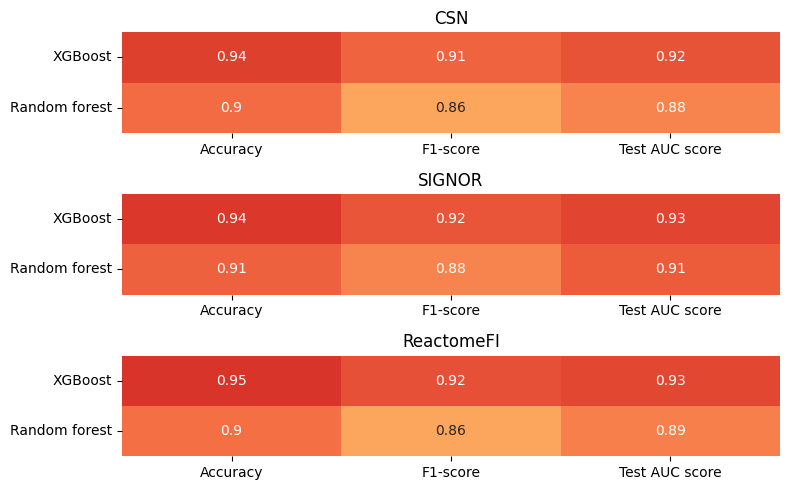

In [22]:
plt.rcParams["figure.figsize"] = [8, 5]
plt.rcParams["figure.autolayout"] = True

fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, sharey=False)
fig.subplots_adjust(wspace=0.01)

vmin = 0.5
vmax = 1

sns.heatmap(params_df_CSN, annot=True, ax=ax1, cbar=False, vmin=vmin, vmax=vmax, cmap="RdYlBu_r")
ax1.set_title('CSN')
sns.heatmap(params_df_SIGNOR, annot=True, ax=ax2, cbar=False, vmin=vmin, vmax=vmax, cmap="RdYlBu_r")
ax2.set_title('SIGNOR')
sns.heatmap(params_df_ReactomeFI, annot=True, ax=ax3, cbar=False, vmin=vmin, vmax=vmax, cmap="RdYlBu_r")
ax3.set_title('ReactomeFI')

plt.show()